<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/%E5%9F%BA%E4%BA%8EMNIST%E5%AE%9E%E7%8E%B0VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

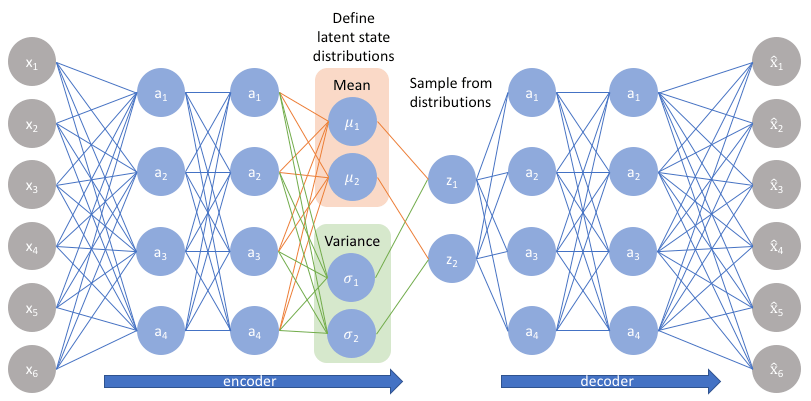

In [2]:
latent_dim = 2
input_dim = 28 * 28
inter_dim = 256

class VAE(nn.Module):
    def __init__(self, input_dim=input_dim, inter_dim=inter_dim, latent_dim=latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, latent_dim * 2),
            # Dont add ReLU anymore!
        )

        self.decoder =  nn.Sequential(
            nn.Linear(latent_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(logvar / 2)

    def forward(self, x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterise(mu, logvar)
        recon_x = self.decoder(z).view(size=org_size)

        return recon_x, mu, logvar

$$
KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)
$$

In [3]:
kl_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
recon_loss = lambda recon_x, x: F.binary_cross_entropy(recon_x, x, size_average=False)

In [4]:
x=torch.randn(3)

In [5]:
epochs = 100
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])
data_train = MNIST('MNIST_DATA/', train=True, download=True, transform=transform)
data_valid = MNIST('MNIST_DATA/', train=False, download=True, transform=transform)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = VAE(input_dim, inter_dim, latent_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_DATA/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATA/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_DATA/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATA/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATA/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATA/MNIST/raw



In [6]:
best_loss = 1e9
best_epoch = 0

valid_losses = []
train_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0.
    train_num = len(train_loader.dataset)

    for idx, (x, _) in enumerate(train_loader):
        batch = x.size(0)
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        recon = recon_loss(recon_x, x)
        kl = kl_loss(mu, logvar)

        loss = recon + kl
        train_loss += loss.item()
        loss = loss / batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Training loss {loss: .3f} \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f} in Step {idx}")

    train_losses.append(train_loss / train_num)

    valid_loss = 0.
    valid_recon = 0.
    valid_kl = 0.
    valid_num = len(test_loader.dataset)
    model.eval()
    with torch.no_grad():
        for idx, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            recon = recon_loss(recon_x, x)
            kl = kl_loss(mu, logvar)
            loss = recon + kl
            valid_loss += loss.item()
            valid_kl += kl.item()
            valid_recon += recon.item()

        valid_losses.append(valid_loss / valid_num)

        print(f"Valid loss {valid_loss / valid_num: .3f} \t Recon {valid_recon / valid_num: .3f} \t KL {valid_kl / valid_num: .3f} in epoch {epoch}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

            torch.save(model.state_dict(), 'best_model_mnist')
            print("Model saved")

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training loss  552.317 	 Recon  552.311 	 KL  0.006 in Step 0
Training loss  205.166 	 Recon  198.894 	 KL  6.273 in Step 100
Training loss  186.817 	 Recon  180.700 	 KL  6.116 in Step 200
Training loss  182.982 	 Recon  177.241 	 KL  5.741 in Step 300
Training loss  181.474 	 Recon  176.072 	 KL  5.402 in Step 400


KeyboardInterrupt: ignored

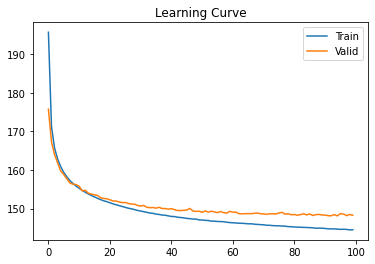

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.title("Learning Curve")
plt.legend();

In [ ]:
import numpy as np
from scipy.stats import norm

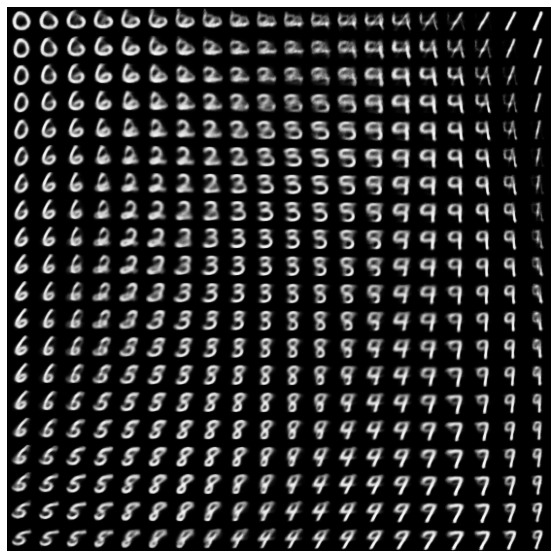

In [ ]:
state = torch.load('best_model_mnist')
model = VAE()
model.load_state_dict(state)


n = 20
digit_size = 28

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


model.eval()
figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        t = [xi, yi]
        z_sampled = torch.FloatTensor(t)
        with torch.no_grad():
            decode = model.decoder(z_sampled)
            digit = decode.view((digit_size, digit_size))
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size
            ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.axis('off')